In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import on_desktop
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import open3d as o3d
from typing import Tuple, Dict, Any
from f3rm.features.clip import clip, tokenize
from f3rm.features.clip.model import CLIP
from f3rm.features.clip_extract import CLIPArgs
from f3rm_robot.optimize import dense_voxel_grid, get_alpha, get_qp_feats
from f3rm_robot.utils import get_heatmap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/vlongle/code/diffPhys3d/third_party/nerfstudio/nerfstudio/field_components/activations.py:32: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float32)
/home/vlongle/code/diffPhys3d/third_party/nerfstudio/nerfstudio/field_components/activations.py:39: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, g):


In [2]:
prefix = "/mnt/kostas-graid/datasets/vlongle/diffphys3d" if not on_desktop() else "."
# result_dir = f"{prefix}/render_outputs/ecb91f433f144a7798724890f0528b23"
result_dir = f"{prefix}/render_outputs/c017d0fb746d4cc48748cca76ad1efad"

In [3]:
alphas = np.load(f"{result_dir}/clip_features_alphas.npy")
grid_feature_path = f"{result_dir}/clip_features.npz"
feature_result = np.load(grid_feature_path)

In [4]:

print("scene bounds", feature_result['min_bounds'], feature_result['max_bounds'])

scene bounds [-0.5 -0.5 -0.5] [0.5 0.5 0.5]


In [5]:
print("density:", np.max(alphas), np.min(alphas), np.mean(alphas))

density: 1.0 0.0 0.05328


In [6]:
## The point cloud is a sparse representation of the voxel grid. 
# Created by just getting the non-empty voxels via `alpha_threshold` (density threshold). 
# Then remove the gray background via `gray_threshold`.
ply_path = f"{result_dir}/clip_features_pc.ply"

In [7]:
import trimesh
pc = trimesh.load(ply_path)
points = np.asarray(pc.vertices)
colors = np.asarray(pc.colors)

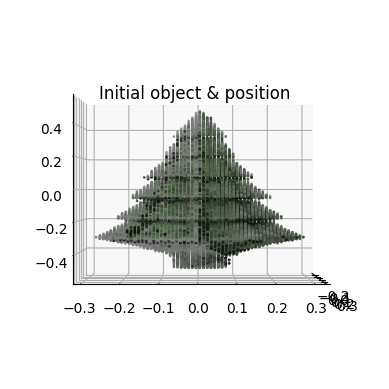

In [8]:
# Visualize initial object & position
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

if colors.max() > 1.0:
    colors = colors / 255.0

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1,
           c=colors)
ax.set_title(f"Initial object & position", y = 0.8)

ax.view_init(elev=0, azim=0)
plt.show()

In [9]:
print("max points coords", np.max(points), np.min(points))

max points coords 0.5 -0.5


In [10]:


def get_initial_voxel_grid_from_saved(
    grid_feature_path: str,
    query: str,
    clip_model,
    device: str = "cuda",
    softmax_temperature: float = 0.1,
    voxel_size: float = 0.01,
    point_cloud_path: str = None  # Add parameter for point cloud path
) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, int]]:
    """
    Get the initial masked voxel grid based on density (alpha) and language (CLIP features).
    This function works with pre-extracted voxel grid data.
    
    Args:
        grid_feature_path: Path to the saved feature grid metadata (.npz file)
        query: Text query to filter voxels
        clip_model: CLIP model for text encoding
        device: Device to use for computation
        alpha_threshold: Threshold for density values
        softmax_temperature: Temperature for softmax when computing language probabilities
        voxel_size: Size of each voxel
        point_cloud_path: Path to pre-filtered point cloud (if None, will use default path)
        
    Returns:
        Tuple containing:
        - voxel_grid: Tensor of shape (num_voxels, 3) containing filtered voxel coordinates
        - voxel_sims: Tensor of shape (num_voxels) containing similarities with language query
        - metrics: Dictionary with metrics about filtering process
    """
    print(f"Loading feature grid from {grid_feature_path}...")
    
    # Load metadata
    metadata = np.load(grid_feature_path)
    min_bounds = metadata['min_bounds']
    max_bounds = metadata['max_bounds']
    grid_shape = metadata['grid_shape']
    
    print(f"Grid shape: {grid_shape}, voxel size: {voxel_size}")
    print(f"Bounds: min={min_bounds}, max={max_bounds}")
    
    # Load features
    features_path = grid_feature_path.replace('.npz', '_features.npy')
    print(f"Loading features from {features_path}...")
    features = np.load(features_path)
    
    # Track metrics
    metrics = {"initial": np.prod(grid_shape)}
    
    # Load the pre-filtered point cloud
    if point_cloud_path is None:
        point_cloud_path = grid_feature_path.replace('.npz', '_pc.ply')
    
    print(f"Loading pre-filtered point cloud from {point_cloud_path}...")
    pc = trimesh.load(point_cloud_path)
    points = np.asarray(pc.vertices)
    
    # Convert points to tensor and move to device
    coords_filtered = torch.tensor(points, dtype=torch.float32, device=device)
    metrics["point_cloud"] = len(coords_filtered)
    print(f"Loaded {len(coords_filtered)} points from point cloud")
    
    # Create a grid of all possible coordinates
    print("Creating coordinate grid...")
    x = torch.linspace(min_bounds[0], max_bounds[0], grid_shape[0], device=device)
    y = torch.linspace(min_bounds[1], max_bounds[1], grid_shape[1], device=device)
    z = torch.linspace(min_bounds[2], max_bounds[2], grid_shape[2], device=device)
    
    grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing='ij')
    all_coords = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)
    
    # Find the nearest grid points for each point in the point cloud
    # This maps the point cloud points back to indices in the feature grid
    print("Finding nearest grid points for point cloud points...")
    
    # For each point in the point cloud, find the closest grid point
    # We'll do this by finding the closest index in each dimension
    indices_x = torch.abs(coords_filtered[:, 0].unsqueeze(1) - x.unsqueeze(0)).argmin(dim=1)
    indices_y = torch.abs(coords_filtered[:, 1].unsqueeze(1) - y.unsqueeze(0)).argmin(dim=1)
    indices_z = torch.abs(coords_filtered[:, 2].unsqueeze(1) - z.unsqueeze(0)).argmin(dim=1)
    
    # Convert to linear indices
    linear_indices = (indices_x * grid_shape[1] * grid_shape[2] + 
                      indices_y * grid_shape[2] + 
                      indices_z)
    
    # Get features for these indices
    features_tensor = torch.from_numpy(features).to(device)
    features_flat = features_tensor.reshape(-1, features_tensor.shape[-1])
    features_filtered = features_flat[linear_indices]
    
    # Feature masking by comparing each voxel's feature with the user query and negatives
    print("Applying language filtering...")
    queries = [query, "object", "things", "stuff", "texture"]  # Negatives from LERF
    
    # Encode text queries
    with torch.no_grad():
        text_inputs = clip.tokenize(queries).to(device)
        query_embs = clip_model.encode_text(text_inputs).float()
        query_embs /= query_embs.norm(dim=-1, keepdim=True)
    
    # Normalize features
    features_filtered = features_filtered.to(torch.float32)
    features_filtered /= features_filtered.norm(dim=-1, keepdim=True)
    
    # Compute similarities and softmax
    voxel_sims = features_filtered @ query_embs.T
    probs = voxel_sims / softmax_temperature
    probs = torch.nn.functional.softmax(probs, dim=-1)
    probs = torch.nan_to_num_(probs, nan=1e-7)
    
    # Sample from distribution, 0-index is the positive query
    labels = torch.multinomial(probs, num_samples=1)
    softmax_mask = (labels == 0).squeeze()
    
    coords_filtered = coords_filtered[softmax_mask]
    voxel_sims_filtered = voxel_sims[:, 0][softmax_mask]
    
    metrics["language_masked"] = len(coords_filtered)
    print(f"After language filtering: {len(coords_filtered)} points")
    
    return coords_filtered, voxel_sims_filtered, metrics

def visualize_filtered_voxels(voxel_grid, voxel_sims=None, title="Filtered Voxels",
                                  view_angles: Tuple[float, float] = (30, 45),):
    """Visualize the filtered voxels with optional heatmap coloring."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    points = voxel_grid.cpu().numpy()
    
    if voxel_sims is not None:
        colors = get_heatmap(voxel_sims,             cmap_name="Reds",
            colormap_min=-1.0,
            colormap_max=1.0,)
    else:
        colors = np.ones((len(points), 3)) * 0.5  # Gray if no similarities
    
    ## add colorbar
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.plasma), ax=ax)
    cbar.set_label('Similarity')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=5)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


    ax.view_init(elev=view_angles[0], azim=view_angles[1])



    # Make axes equal for better visualization
    # Get the limits
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    
    # Calculate the range for each axis
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    
    # Find the largest range
    max_range = max(x_range, y_range, z_range) / 2.0
    
    # Set the limits based on the center and the max range
    x_mid = (x_limits[1] + x_limits[0]) / 2
    y_mid = (y_limits[1] + y_limits[0]) / 2
    z_mid = (z_limits[1] + z_limits[0]) / 2
    
    ax.set_xlim3d([x_mid - max_range, x_mid + max_range])
    ax.set_ylim3d([y_mid - max_range, y_mid + max_range])
    ax.set_zlim3d([z_mid - max_range, z_mid + max_range])
    
    plt.tight_layout()
    return fig

def save_filtered_point_cloud(voxel_grid, voxel_sims, output_path):
    """Save the filtered voxels as a point cloud with heatmap coloring."""
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(voxel_grid.cpu().numpy())
    
    # Color by similarity
    colors = get_heatmap(voxel_sims)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Save to file
    o3d.io.write_point_cloud(output_path, pcd)
    print(f"Saved filtered point cloud to {output_path}")
    return pcd

def main(grid_feature_path, query, output_dir="./filtered_results", device="cuda"):
    """Main function to run the filtering pipeline."""
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Load CLIP model
    clip_model, _ = clip.load(CLIPArgs.model_name, device=device)
    
    # Get filtered voxel grid
    voxel_grid, voxel_sims, metrics = get_initial_voxel_grid_from_saved(
        grid_feature_path,
        query,
        clip_model,
        device=device
    )
    
    # Visualize results
    fig = visualize_filtered_voxels(voxel_grid, voxel_sims, f'Filtered Voxels for "{query}"')
    fig.savefig(output_dir / f"{query}_filtered_voxels.png")
    
    # Save as point cloud
    # save_filtered_point_cloud(voxel_grid, voxel_sims, str(output_dir / f"{query}_filtered.ply"))
    
    # Save metrics
    with open(output_dir / f"{query}_metrics.txt", "w") as f:
        for key, value in metrics.items():
            f.write(f"{key}: {value}\n")
    
    return voxel_grid, voxel_sims, metrics

In [15]:
# query="leaves" ## work for leaves, pot, ficus (leaves + trunk). Doesn't work for trunk, wood ect.
query="trunk" ## work for leaves, pot, ficus (leaves + trunk). Doesn't work for trunk, wood ect.

Loading feature grid from ./render_outputs/c017d0fb746d4cc48748cca76ad1efad/clip_features.npz...
Grid shape: [100 100 100], voxel size: 0.01
Bounds: min=[-0.5 -0.5 -0.5], max=[0.5 0.5 0.5]
Loading features from ./render_outputs/c017d0fb746d4cc48748cca76ad1efad/clip_features_features.npy...
Loading pre-filtered point cloud from ./render_outputs/c017d0fb746d4cc48748cca76ad1efad/clip_features_pc.ply...
Loaded 49593 points from point cloud
Creating coordinate grid...
Finding nearest grid points for point cloud points...
Applying language filtering...
After language filtering: 9736 points


(tensor([[ 0.2475,  0.0051, -0.2576],
         [ 0.2374,  0.0455, -0.2980],
         [ 0.2374,  0.0152, -0.3081],
         ...,
         [ 0.1061, -0.1667, -0.3283],
         [ 0.1061, -0.1667, -0.3182],
         [-0.0354, -0.0758,  0.1263]], device='cuda:0'),
 tensor([0.1677, 0.1536, 0.1521,  ..., 0.1486, 0.1460, 0.1985], device='cuda:0'),
 {'initial': 1000000, 'point_cloud': 49593, 'language_masked': 9736})

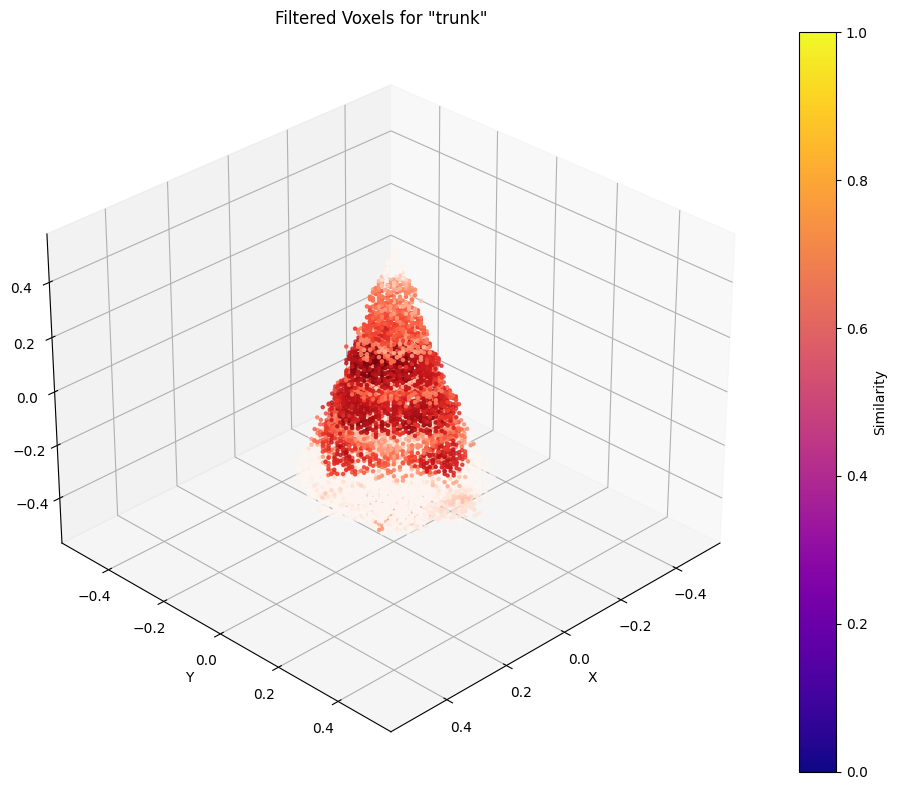

In [16]:
main(grid_feature_path, query, output_dir="./filtered_results", device="cuda")